<a href="https://colab.research.google.com/github/ankisile/ASHRAE-Great-Energy-Predictor-III/blob/main/ASHRAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c ashrae-energy-prediction

 97% 161M/167M [00:01<00:00, 121MB/s]
100% 167M/167M [00:01<00:00, 133MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 84.5MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 171MB/s]
100% 120M/120M [00:01<00:00, 114MB/s]

 81% 72.0M/88.4M [00:00<00:00, 123MB/s]
100% 88.4M/88.4M [00:00<00:00, 138MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 45.3MB/s]


In [ ]:
! unzip -q sample_submission.csv.zip
! unzip -q test.csv.zip
! unzip -q train.csv.zip
! unzip -q weather_test.csv.zip
! unzip -q weather_train.csv.zip

There are 4 types of energy to predict

- 0 : electricity
- 1 : chilledwater
- 2 : steam
- 3 : hotwater

Electricity and water consumption may have different behavior!

 - I will make separately train & predict the model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

In [ ]:
train_df = pd.read_csv('train.csv')
weather_train_df = pd.read_csv('weather_train.csv')

# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_meta_df = pd.read_csv('building_metadata.csv')


# Utility Functions

In [ ]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month

     # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


In [ ]:
def features_engineering(df):
    
       
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [ ]:
weather_train_df = fill_weather_dataset(weather_train_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_meta_df = reduce_mem_usage(building_meta_df,use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.66 MB
Decreased by 72.5%


In [ ]:
train_df = train_df.merge(building_meta_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_train_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_train_df
gc.collect()

88

In [ ]:
train_df = features_engineering(train_df)

In [ ]:
train_df.head(20)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,105,0,23.303600,1,0,10.832181,3.800781,0.0,2.400391,0.0,0,4
1,106,0,0.374600,1,0,8.589514,3.800781,0.0,2.400391,0.0,0,4
2,106,3,0.000000,1,0,8.589514,3.800781,0.0,2.400391,0.0,0,4
3,107,0,175.184006,1,0,11.487946,3.800781,0.0,2.400391,0.0,0,4
4,108,0,91.265297,1,0,11.309352,3.800781,0.0,2.400391,0.0,0,4
5,109,0,80.930000,1,0,10.950736,3.800781,0.0,2.400391,0.0,0,4
6,109,3,0.000000,1,0,10.950736,3.800781,0.0,2.400391,0.0,0,4
7,110,0,86.228302,1,0,10.233331,3.800781,0.0,2.400391,0.0,0,4
8,111,0,167.391998,1,0,11.681309,3.800781,0.0,2.400391,0.0,0,4
9,112,0,10.274800,1,0,10.379939,3.800781,0.0,2.400391,0.0,0,4


In [ ]:
target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)
del train_df
gc.collect()

88

In [ ]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}
kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.09001	valid_1's rmse: 1.24673
[50]	training's rmse: 0.896403	valid_1's rmse: 1.1325
[75]	training's rmse: 0.829505	valid_1's rmse: 1.1172
[100]	training's rmse: 0.791005	valid_1's rmse: 1.11749
[125]	training's rmse: 0.763006	valid_1's rmse: 1.12057
Early stopping, best iteration is:
[88]	training's rmse: 0.808	valid_1's rmse: 1.11664
Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.09654	valid_1's rmse: 1.2114
[50]	training's rmse: 0.90706	valid_1's rmse: 1.07634
[75]	training's rmse: 0.846507	valid_1's rmse: 1.04255
[100]	training's rmse: 0.813772	valid_1's rmse: 1.0352
[125]	training's rmse: 0.788703	valid_1's rmse: 1.03126
[150]	training's rmse: 0.771408	valid_1's rmse: 1.03218
[175]	training's rmse: 0.758719	valid_1's rmse: 1.03258
Early stopping, best iteration is:
[138]	training's rmse: 0.779296	valid_1's rmse: 1.03104
Training until validation scores don't 

In [ ]:
del features, target
gc.collect()

602

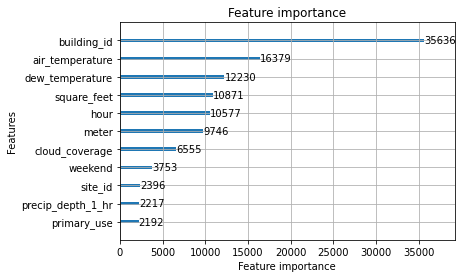

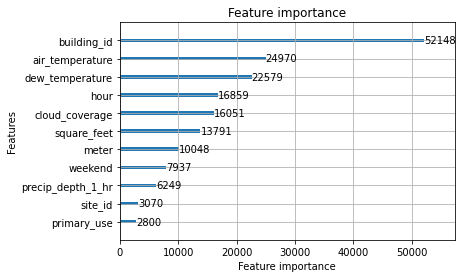

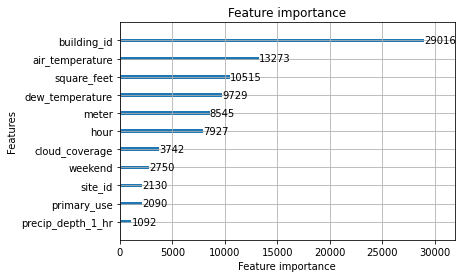

In [ ]:
for model in models:
    lgb.plot_importance(model)
    plt.show()


In [ ]:
test_df = pd.read_csv('test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


In [ ]:
test_df = test_df.merge(building_meta_df,left_on='building_id',right_on='building_id',how='left')
del building_meta_df
gc.collect()

11758

In [ ]:
weather_df = pd.read_csv('weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 9.05 MB
Decreased by 53.0%


In [ ]:
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

189

In [ ]:
test_df = features_engineering(test_df)

In [ ]:
test_df.shape

(41697600, 11)

In [ ]:
# results = []
# for model in models:
#     if  results == []:
#         results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
#     else:
#         results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
#     del model
#     gc.collect()



stepsize = 1000000
results = np.zeros(test_df.shape[0])
for model in models:
  predictions = []
  for i in range(0, test_df.shape[0], stepsize):
    predictions.append(np.expm1(model.predict(test_df.loc[i:i+stepsize-1,:], num_iteration=model.best_iteration)))
  results += (1 / len(models)) * np.concatenate(predictions, axis=0)
  del model


In [ ]:
del test_df, models
gc.collect()

566

In [ ]:

# assert(results.shape[0] == test_.shape[0])    
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, None)})
results_df.to_csv("submission.csv", index=False)

# results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
# del row_ids,results
# gc.collect()
# results_df.to_csv("submission.csv", index=False)

In [ ]:
results_df.head(20)

,row_id,meter_reading
0,0,186.168107
1,1,85.102571
2,2,13.020658
3,3,249.669041
4,4,1130.942372
5,5,25.602277
6,6,96.963811
7,7,436.188862
8,8,358.571677
9,9,318.887387
